# SYSTEM RUN

In [179]:
import hoomd
import hoomd.hpmc
import ex_render
import math
import random
from scipy.spatial import distance_matrix
from shapely.geometry import Polygon
import numpy as np
import matplotlib.pyplot as plt
import glob
import re
hoomd.context.initialize("--mode=cpu")
from freud import parallel, box, density, order
parallel.setNumThreads(2)
from bokeh.io import output_notebook
output_notebook()
from bokeh.plotting import figure, output_file, show
from bokeh.layouts import gridplot
import numpy as np
from scipy import stats, polyfit
import matplotlib.pyplot as plt
from scipy.interpolate import Rbf
from matplotlib import cm
import freud
import xlwt

def polygon(n, a, alpha0, p0):
    l = []
    p = [0, a]
    p = [p[0]*math.cos(alpha0) - p[1]*math.sin(alpha0), p[1]*math.cos(alpha0) + p[0]*math.sin(alpha0)]
    alpha = 2*math.pi/n
    for i in range(n):
        p = [p[0]*math.cos(alpha) - p[1]*math.sin(alpha), p[1]*math.cos(alpha) + p[0]*math.sin(alpha)]
        l.append([p[0]+p0[0], p[1]+p0[1]])
    return l

def hex_flake_step(old_line):
    new_line = []
    for i in range(len(old_line)-1):
        p1 = old_line[i]
        p2 = old_line[i+1]
        dpx = (p2[0] - p1[0])/3.0
        dpy = (p2[1] - p1[1])/3.0
        new_line.append(p1)
        p3 = [p1[0]+dpx, p1[1]+dpy]
        p4 = [p1[0]+2*dpx, p1[1]+2*dpy]
        alpha = math.pi/3.0
        p = [(p2[0]-p1[0])/3.0, (p2[1]-p1[1])/3.0]
        p5 = [p[0]*math.cos(alpha) - p[1]*math.sin(alpha), p[1]*math.cos(alpha) + p[0]*math.sin(alpha)]
        p5 = [p5[0] + p3[0], p5[1] + p3[1]]
        new_line.append(p3)
        new_line.append(p5)
        new_line.append(p4)
    p1 = old_line[-1]
    p2 = old_line[0]
    dpx = (p2[0] - p1[0])/3.0
    dpy = (p2[1] - p1[1])/3.0
    new_line.append(p1)
    p3 = [p1[0]+dpx, p1[1]+dpy]
    p4 = [p1[0]+2*dpx, p1[1]+2*dpy]
    alpha = math.pi/3.0
    p = [(p2[0]-p1[0])/3.0, (p2[1]-p1[1])/3.0]
    p5 = [p[0]*math.cos(alpha) - p[1]*math.sin(alpha), p[1]*math.cos(alpha) + p[0]*math.sin(alpha)]
    p5 = [p5[0] + p3[0], p5[1] + p3[1]]
    new_line.append(p3)
    new_line.append(p5)
    new_line.append(p4)
    #new_line.append(old_line[-1])
    new_line = np.array(new_line)
    return new_line

def GetPhi(r, it):
    ######
    vertex = []
    rad_hex = r
    rho = rad_hex**2
    #Hexagon1
    p_hex1 = [0, 0.5*rad_hex, 0]
    hex1_line = polygon(6, rad_hex, 0, p_hex1[0:2])
    hex_line = np.copy(hex1_line)
    for i in range(it):
        hex_line = hex_flake_step(hex_line)
    vertex.append(hex1_line)
    hex1 = Polygon(hex_line)
    #Cell hexagon
    hex_cell_line = polygon(6, 1, 0, p_hex1[0:2])
    hex_cell = Polygon(hex_cell_line)
    phi = hex1.area/hex_cell.area
    ######
    return phi

def GetSquare(r, it):
    ######
    vertex = []
    rad_hex = r
    rho = rad_hex**2
    #Hexagon1
    p_hex1 = [0, 0.5*rad_hex, 0]
    hex1_line = polygon(6, rad_hex, 0, p_hex1[0:2])
    hex_line = np.copy(hex1_line)
    for i in range(it):
        hex_line = hex_flake_step(hex_line)
    vertex.append(hex1_line)
    hex1 = Polygon(hex_line)
    ######
    return hex1.area

In [ ]:
rad_hex = 1
rad_mul = 0.85
coords = []
vertex = []
types = []
diameters=[]

#Hexagon1
itr1 = 0
p_hex1 = [0, 0.5*rad_hex, 0]
coords.append(p_hex1)
vertex.append(polygon(6, rad_mul*rad_hex, 0, p_hex1[0:2]))
types.append('A')
diameters.append(2*rad_hex)
#Hexagon2
iter2 = 1
p_hex2 = [rad_hex*np.sqrt(3)/2, -rad_hex ,0]
coords.append(p_hex2)
vertex.append(polygon(6, rad_mul*rad_hex, 0, p_hex2[0:2]))
types.append('A')
diameters.append(2*rad_hex)

sqr_hex = 6*rad_hex**2*math.cos(math.pi/6)*math.sin(math.pi/6)
etta = sqr_hex / 0.866025403784
print rad_mul**2

uc = hoomd.lattice.unitcell(N=2,
                            a1=[rad_hex*np.sqrt(3), 0, 0],
                            a2=[0, 3*rad_hex, 0],
                            a3=[0,   0,   1],
                            dimensions=2,
                            position=coords,
                            diameter=diameters,
                            type_name=types);

system = hoomd.init.create_lattice(unitcell=uc, n=[50, 30]);
mc = hoomd.hpmc.integrate.convex_polygon(d=0.01, a=0.01, seed=2432);
square_verts = vertex[0];
mc.shape_param.set('A', vertices=square_verts)

In [194]:
mult_poly = 0.2#0.2
count_box = 1 #8
dx, dy = 1.0/count_box, 1.0/count_box
rad_poly = mult_poly/(2*count_box)
rad_hex = 0.5 #4
n_vertex = 21
coords = []
vertex = []
types = []
diameters=[]

#Hexagon
p_hex = [0,0,0]
coords.append(p_hex)
vertex.append(polygon(6, rad_hex, math.pi/6, p_hex[0:2]))
types.append('A')
diameters.append(2*rad_hex)
hex_coords = []
for v in vertex[0]:
    hex_coords.append((p_hex[0]+v[0], p_hex[1]+v[1]))
hex_obj = Polygon(hex_coords)

#Small-polygons (disks) lattice constructor
count_poly = 0
for i in range(count_box):
    for j in range(count_box):
        x, y = -0.5 + dx/2 + i*dx, -0.5 + dy/2 + j*dy
        poly_coords = polygon(n_vertex, rad_poly, 0, [x, y])
        poly_obj = Polygon(poly_coords)
        #Adding disk to lattice if the one dont intersecting hexagone
        if hex_obj.intersects(poly_obj) == False:
            coords.append([x, y, 0])
            vertex.append(polygon(n_vertex, rad_poly, 0, [0, 0]))
            types.append('B')
            diameters.append(2*rad_poly)
            count_poly += 1
sqr_hex = 6*rad_hex**2*math.cos(math.pi/6)*math.sin(math.pi/6)
sqr_poly = count_poly*n_vertex*rad_poly**2*math.cos(math.pi/n_vertex)*math.sin(math.pi/n_vertex)
etta = (sqr_hex + sqr_poly)
print etta, count_poly

0.649519052838 0


In [182]:
uc = hoomd.lattice.unitcell(N=count_poly + 1,
                            a1=[1.0, 0, 0],
                            a2=[0, 1.0, 0],
                            a3=[0, 0, 1.0],
                            dimensions=2,
                            position=coords,
                            diameter=diameters,
                            type_name=types);

In [183]:
system = hoomd.init.create_lattice(unitcell=uc, n=[20, 20]);

notice(2): Group "all" created containing 400 particles


In [185]:
mc = hoomd.hpmc.integrate.convex_polygon(d=0.01, a=0.01, seed=334);
square_vertsA = vertex[0];
mc.shape_param.set('A', vertices=square_vertsA);
if count_poly > 0:
    square_vertsB = vertex[1];
    mc.shape_param.set('B', vertices=square_vertsB);

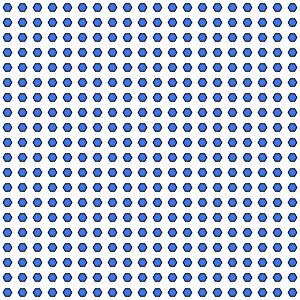

In [193]:
if count_poly > 0:
    ex_render.render_2polygons_frame(system.take_snapshot(all=True), square_vertsA, square_vertsB)
ex_render.render_polygon_frame(system.take_snapshot(all=True), square_vertsA)

In [25]:
d = hoomd.dump.gsd("trajectory.gsd", period=1000, group=hoomd.group.all(), overwrite=True);

In [26]:
hoomd.run(20000);

** starting run **
Time 00:00:18 | Step 283 / 20000 | TPS 28.1809 | ETA 00:11:39
Time 00:00:28 | Step 561 / 20000 | TPS 27.7246 | ETA 00:11:41
Time 00:00:38 | Step 845 / 20000 | TPS 28.3902 | ETA 00:11:14
Time 00:00:48 | Step 1129 / 20000 | TPS 28.3304 | ETA 00:11:06
Time 00:00:58 | Step 1405 / 20000 | TPS 27.506 | ETA 00:11:16
Time 00:01:08 | Step 1681 / 20000 | TPS 27.5157 | ETA 00:11:05
Time 00:01:18 | Step 1959 / 20000 | TPS 27.7176 | ETA 00:10:50
Time 00:01:28 | Step 2239 / 20000 | TPS 27.9538 | ETA 00:10:35
Time 00:01:38 | Step 2514 / 20000 | TPS 27.4624 | ETA 00:10:36
Time 00:01:48 | Step 2793 / 20000 | TPS 27.8041 | ETA 00:10:18
Time 00:01:58 | Step 3071 / 20000 | TPS 27.7935 | ETA 00:10:09
Time 00:02:08 | Step 3340 / 20000 | TPS 26.898 | ETA 00:10:19
Time 00:02:18 | Step 3598 / 20000 | TPS 25.7891 | ETA 00:10:36
Time 00:02:28 | Step 3872 / 20000 | TPS 27.3235 | ETA 00:09:50
Time 00:02:38 | Step 4152 / 20000 | TPS 27.9214 | ETA 00:09:27
Time 00:02:48 | Step 4433 / 20000 | TPS 2

In [27]:
tr = ex_render.get_trajectory("trajectory.gsd")
len(tr)

20

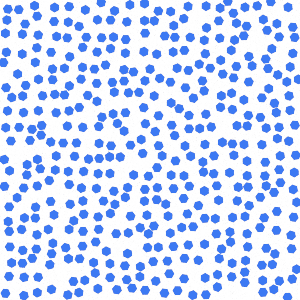

In [28]:
if count_poly > 0:
    ex_render.render_2polygons_frame(tr[-1], square_vertsA, square_vertsB)
else:
    ex_render.render_polygon_frame(tr[-1], square_vertsA)

# COMPUTE 1D RDF

In [1]:
from freud import parallel, box, density
parallel.setNumThreads(4)
from bokeh.io import output_notebook
output_notebook()
from bokeh.plotting import figure, output_file, show
from bokeh.layouts import gridplot
import numpy as np

def default_bokeh(p):
    p.title.text_font_size = "18pt"
    p.title.align = "center"

    p.xaxis.axis_label_text_font_size = "14pt"
    p.yaxis.axis_label_text_font_size = "14pt"

    p.xaxis.major_tick_in = 10
    p.xaxis.major_tick_out = 0
    p.xaxis.minor_tick_in = 5
    p.xaxis.minor_tick_out = 0

    p.yaxis.major_tick_in = 10
    p.yaxis.major_tick_out = 0
    p.yaxis.minor_tick_in = 5
    p.yaxis.minor_tick_out = 0

    p.xaxis.major_label_text_font_size = "12pt"
    p.yaxis.major_label_text_font_size = "12pt"

Loading BokehJS ...

In [79]:
p_index = 0
tid = tr[0].particles.typeid == p_index
n_par = len(tr[0].particles.position[tid, 0])
p = np.zeros((n_par, 3), dtype=np.float32)
rdf = density.RDF(rmax=tr[0].configuration.box[0]/2, dr=0.1)
# compute the rdf for for all frames except the first (your syntax will vary based on your reader)
frame_begin = 9
frame_end = 10
frame_period = 1
# compute the rdf for for first frame
fbox = box.Box(Lx=tr[0].configuration.box[0], Ly=tr[0].configuration.box[1], is2D=True)
rdf.compute(fbox, p, p)
p[:, :] = tr[frame_begin].particles.position[tid, 0:3]
p[:, 2] = 0
for i in range(frame_begin, frame_end):
    # read box, position data
    if i % frame_period == 0:
        print "Frame #", i, " process"
    p[:, :] = tr[i].particles.position[tid, 0:3]
    p[:, 2] = 0
    # create the freud box object
    fbox = box.Box(Lx=tr[0].configuration.box[0], Ly=tr[0].configuration.box[1], is2D=True)
    # accumulate
    rdf.accumulate(fbox, p, p)

Frame # 9  process


In [80]:
# get the center of the histogram bins
r = rdf.getR()
# get the value of the histogram bins
y = rdf.getRDF()
# create bokeh plot
p = figure(title="RDF", x_axis_label='r', y_axis_label='g(r)')
p.line(r, y, legend="g(r)", line_width=2)
default_bokeh(p)
show(p)

# COMPUTE 2D RDF

In [138]:
import numpy, math, random
import matplotlib.pyplot as plt
import sys, os
import glob
import numpy as np
import time

In [139]:
trs = glob.glob("./tr*")

In [140]:
print trs

['./trajectory_0.60525661536.gsd', './trajectory_0.51240873542.gsd', './trajectory_0.450510148794.gsd', './trajectory_0.729053788612.gsd', './trajectory.gsd']


In [154]:
tr = ex_render.get_trajectory(trs[3])
len(tr)

11

Sigma # 0 : Frame # 10  process
Sigma # 1 : Frame # 10  process
Sigma # 2 : Frame # 10  process
Sigma # 3 : Frame # 10  process
Solving time is  52.6058390141  sec.


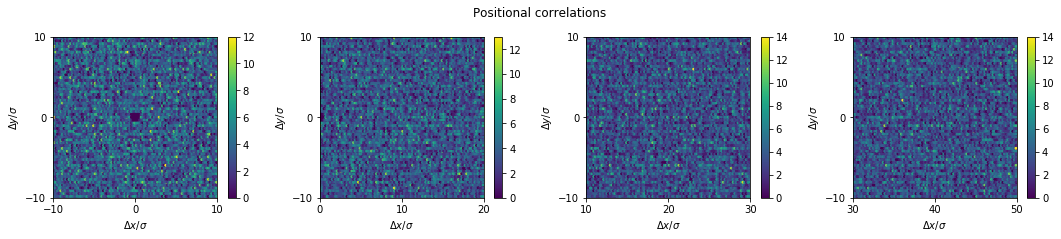

In [155]:
p_index = 0
box = tr[0].configuration.box
tid = tr[0].particles.typeid == p_index
N = len(tr[0].particles.position[tid, 0])
p = np.zeros((N, 3), dtype=np.float32)
sigma = 0.01
n_sigma = 10
delta = n_sigma*sigma
x_dist = [0*sigma, n_sigma*sigma, 2*n_sigma*sigma, 4*n_sigma*sigma]
x_draw = [[], [], [], []]
y_draw = [[], [], [], []]
M = 100
frame_begin = 10
frame_end = 11
frame_period = 1
b_time = time.time()
for isg in xrange(4):
    for ifr in range(frame_begin, frame_end):
        if ifr % frame_period == 0:
            print "Sigma #", isg, ": Frame #", ifr, " process"
        p[:, :] = tr[ifr].particles.position[tid, 0:3]
        p[:, 2] = 0
        p[:, 0] /= box[0]
        p[:, 1] /= box[1]
        for k in xrange(M*N):
            i = numpy.random.randint(0,N)
            j = numpy.random.randint(0,N)
            yy=(p[j,1]-p[i,1])%1.0
            if yy > 0.5: yy-=1.0
            if abs(yy) < delta:
                xx=(p[j,0]-p[i,0])%1.0
                if xx > 0.5: xx-=1.0
                if abs(xx-x_dist[isg]) < delta and i!=j:
                    x_draw[isg].append(xx/sigma)
                    y_draw[isg].append(yy/sigma)
e_time = time.time()
print "Solving time is ", e_time - b_time, " sec."
plt.figure(figsize=(18,3.2))
plt.suptitle('Positional correlations')
plt.subplots_adjust(wspace=.3,bottom=0.15,top=0.85)
for k in xrange(4):
    plt.subplot(1,4,k+1)
    ymin=-n_sigma
    ymax=n_sigma
    xmin=x_dist[k]/sigma - n_sigma
    xmax=x_dist[k]/sigma + n_sigma
    plt.hexbin(x_draw[k],y_draw[k], gridsize=100)
    plt.axis([xmin,xmax,ymin,ymax])
    plt.xlabel("$\Delta x/\sigma$")
    plt.ylabel("$\Delta y/\sigma$",x=30.)
    plt.yticks([-n_sigma,0,n_sigma])
    plt.xticks([xmin,xmin+n_sigma,xmax])
    cb = plt.colorbar()
plt.show()

# COMPUTE HEXATIC ORDER PARAMETER

In [143]:
from bokeh.io import output_notebook
output_notebook()
from bokeh.plotting import figure, output_file, show
from bokeh.layouts import gridplot
import numpy as np
import time
import PIL.Image
import io
import IPython.display
from freud import parallel
parallel.setNumThreads(4)

# helper functions used in the notebook are below; you are free to disregard

def showarray(a, fmt='png'):
    """
    uses PIL to display an image rendered externally.
    
    Currently not used
    """
    f = io.BytesIO()
    PIL.Image.fromarray(a, mode='RGBA').save(f, fmt)
#     PIL.Image.fromarray(a, mode='RGBA').save("out.png")
    return IPython.display.display(IPython.display.Image(data=f.getvalue(), width=600))

def default_bokeh(p):
    """
    wrapper which takes the default bokeh outputs and changes them to more sensible values
    """
    p.title.text_font_size = "18pt"
    p.title.align = "center"

    p.xaxis.axis_label_text_font_size = "14pt"
    p.yaxis.axis_label_text_font_size = "14pt"

    p.xaxis.major_tick_in = 10
    p.xaxis.major_tick_out = 0
    p.xaxis.minor_tick_in = 5
    p.xaxis.minor_tick_out = 0

    p.yaxis.major_tick_in = 10
    p.yaxis.major_tick_out = 0
    p.yaxis.minor_tick_in = 5
    p.yaxis.minor_tick_out = 0

    p.xaxis.major_label_text_font_size = "12pt"
    p.yaxis.major_label_text_font_size = "12pt"

def cubeellipse(theta, lam=0.5, gamma=1., s=4.0, r=1., h=1.):
    """Create an RGB colormap from an input angle theta. Takes lam (a list of
    intensity values, from 0 to 1), gamma (a nonlinear weighting power),
    s (starting angle), r (number of revolutions around the circle), and
    h (a hue factor)."""
    import numpy
    lam = lam**gamma

    a = h*lam*(1 - lam)*.5
    v = numpy.array([[-.14861, 1.78277], [-.29227, -.90649], [1.97294, 0.]], dtype=numpy.float32)
    ctarray = numpy.array([numpy.cos(theta*r + s), numpy.sin(theta*r + s)], dtype=numpy.float32)
    # convert to 255 rgb
    ctarray = (lam + a*v.dot(ctarray)).T
    ctarray *= 255
    ctarray = ctarray.astype(dtype=np.int32)
    return ctarray

def local_to_global(verts, positions, orientations):
    """
    Take a list of vertices, positions, and orientations and create
    a list of vertices in the "global coordinate system" for plotting
    in bokeh
    """
    num_particles = len(positions)
    num_verts = len(verts)
    # create list of vertices in the "local reference frame" i.e.
    # centered at (0,0)
    l_verts = np.zeros(shape=(num_particles, num_verts, 2), dtype=np.float32)
    l_verts[:] = verts
    # create array of rotation matrices
    rot_mat = np.zeros(shape=(num_particles, 2, 2), dtype=np.float32)
    for i, theta in enumerate(orientations):
        rot_mat[i] = [[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]]
    # rotate; uses einsum for speed; please see numpy documentation
    # for more information
    r_verts = np.einsum("lij,lkj->lki", rot_mat, l_verts)
    # now translate to global coordinates
    # need to create a position array with same shape as vertex array
    l_pos = np.zeros(shape=(num_particles, num_verts, 2), dtype=np.float32)
    for i in range(num_particles):
        for j in range(len(verts)):
            l_pos[i,j] = positions[i]
    # translate
    output_array = np.add(r_verts, l_pos)
    return output_array

def clamp(x):
    """
    limit values between 0 and 255
    http://stackoverflow.com/questions/3380726/converting-a-rgb-color-tuple-to-a-six-digit-code-in-python
    """
    return max(0, min(x, 255))

Loading BokehJS ...

In [168]:
from freud import box, order

def GetHexatic(frame_ind, rmax):
    # create hexatic object
    hex_order = order.HexOrderParameter(rmax=rmax, k=6, n=6);
    p_index = 0
    tid = tr[frame_ind].particles.typeid == p_index
    n_par = len(tr[frame_ind].particles.position[tid, 0])
    pos_data = np.zeros((n_par, 3), dtype=np.float32)
    # compute the hexatic order
    pos_data[:, :] = tr[frame_ind].particles.position[tid, 0:3]
    pos_data[:, 2] = 0
    ang_data = 2*numpy.arctan2(np.copy(tr[frame_ind].particles.orientation[tid,3]), 
                             np.copy(tr[frame_ind].particles.orientation[tid,0]))
    # create box
    fbox = box.Box(Lx=tr[0].configuration.box[0], Ly=tr[0].configuration.box[1], is2D=True)
    # compute hexatic order for 6 nearest neighbors
    hex_order.compute(fbox, pos_data)
    # get values from freud object
    psi_k = hex_order.getPsi()
    avg_psi_k = np.mean(psi_k)
    return (psi_k, avg_psi_k, ang_data, pos_data)

# render in bokeh
# vertex positions for hexagons
data = GetHexatic(-1, 7)
psi_k = data[0]
avg_psi_k = data[1]
ang_data = data[2]
pos_data = data[3]
verts = np.array(vertex[0])*2
# create array of transformed positions
patches = local_to_global(verts, pos_data[:, 0:2], ang_data)
# create an array of angles relative to the average
a = np.angle(psi_k) - np.angle(avg_psi_k)
# turn into an rgb array of tuples
color = [tuple(cubeellipse(x)) for x in a]
# bokeh (as of this version) requires hex colors, so convert rgb to hex
hex_color = ["#{0:02x}{1:02x}{2:02x}".format(clamp(r), clamp(g), clamp(b)) for (r,g,b) in color]
# plot
p = figure(title="Hexatic Order Parameter visualization")
p.patches(xs=patches[:,:,0].tolist(), ys=patches[:,:,1].tolist(),
    fill_color=hex_color, line_color="black")
default_bokeh(p)
show(p)

#  COMPUTE $ G_6(t)$

In [145]:
import numpy, math, random
import matplotlib.pyplot as plt
import ex_render

In [172]:
psi_k_mas = []
for i, frame in enumerate(tr):
    data = GetHexatic(i, 10)
    psi_k = data[0]
    avg_psi_k = data[1]
    ang_data = data[2]
    pos_data = data[3]
    psi_k_mas.append(psi_k)
    
psi_k_mas = np.array(psi_k_mas)

In [173]:
psi_k_0 = psi_k_mas[0]
psi_k_0_abs2 = np.abs(psi_k_0)**2
g6 = np.zeros(len(psi_k_mas))
for i in range(len(psi_k_mas)):
    non_zero_inds = psi_k_0_abs2 > 0
    g6[i] = np.real(np.mean(psi_k_mas[i, non_zero_inds]*np.conj(psi_k_0[non_zero_inds]) / psi_k_0_abs2[non_zero_inds]))

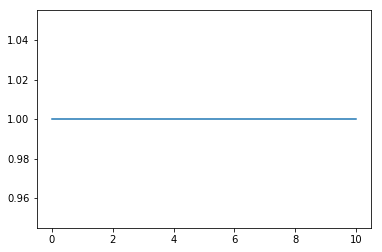

In [174]:
plt.plot(g6)
plt.show()

In [152]:
len(psi_k_0)

10000